<a href="https://colab.research.google.com/github/marcinluczkowski/structuralCircle/blob/main/MappingAlgorithms/MappingAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

TEST!

Task: having `dsgn` set as our objective, find most optimal choice of elements using the material bank dataset and new elements. 

Optimization should take into account:
*   technical feasibility - element can't be shorter or have smaller area than  required
*   minimization of waste volume, expressed in terms of LCA
*   price, assuming  that we pay for whole elements and don't sell scrap waste.



# Input data

### Abbreviations

dsgn - New Design

bank - Material Bank (collection of preowned, available elements)

LCA - Life Cycle Assessment - Global Warming Potential (GWP) expressed in kilograms of CO2 equivalent of all the emited green-house gases (kgCO2e). 

### Input assumptions
First assumption is that we only consider timber. Steel or concrete could yield more significant savings due to their high carbon footprint. 

In [ ]:
NEW_PRICE = 8000    # [NOK/m3], based on average from https://www.byggmax.no/catalogsearch/result/?q=KONSTRUKSJONSVIRKE
NEW_LCA_GWP_A1_A3 = 28.9 # [kgCO2e/m3], assuming 'fossil GWP' and 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
NEW_LCA_GWP_A5 = 1.59   # [kgCO2e/m3], assuming 'fossil GWP' and 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
NEW_DISTANCE = 100  # [km], maybe it should be variable e.g. 0-500km, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html

DENSITY = 491                 # [kg/m3], assuming 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
TRANSPORT_LCA_GWP = 0.0318    # [kgCO2e/km], assuming 45% (90% and 0% back) utilisation of 34t truck, burning 0.027 l/tonkm (both ways), based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
# TRANSPORT_PRICE = ???       # [nok/tonkm], ?

MIN_LENGTH = 1.0    # [m]
MAX_LENGTH = 12.0   # [m]
MIN_AREA = 0.0025   # [m2], 5x5cm
MAX_AREA = 0.125    # [m2], 25x50cm

DSGN_COUNT = 5
BANK_COUNT = 20

BANK_DISTANCE = [50, 100, 150] # [km], random of this list that represents multiple preowned elements stocks 
BANK_LCA_GWP_A1_A3 = NEW_LCA_GWP_A1_A3 * 0.0778     # [kgCO2e/m3], based on new product and factor derived from (Eberhardt, 2020)
BANK_LCA_GWP_A5 = NEW_LCA_GWP_A5                    # [kgCO2e/m3], assuming it is the same as for new product
BANK_PRICE = 4000         # [NOK/m3], based on Ormondroyd et al. (2016), where used beam 9"x1.5"x16ft costs 14gbp, so approximately 168 NOK, so a cubic meter appr. 4020nok. TODO: better analysis would be valuable.

\* TODO we need to explain in paper which allocation method for LCA we select. Well described in (Eberhardt, 2020). I assumed for now the most common cut-off, and that we are at the second cycle (even though in Oslo it will be third). I just multiplied the new LCA for EPD product and multiplied by 7/90=0.0778. It is not the correct simplification!

https://www.researchgate.net/publication/347002003_Development_of_a_Life_Cycle_Assessment_Allocation_Approach_for_Circular_Economy_in_the_Built_Environment

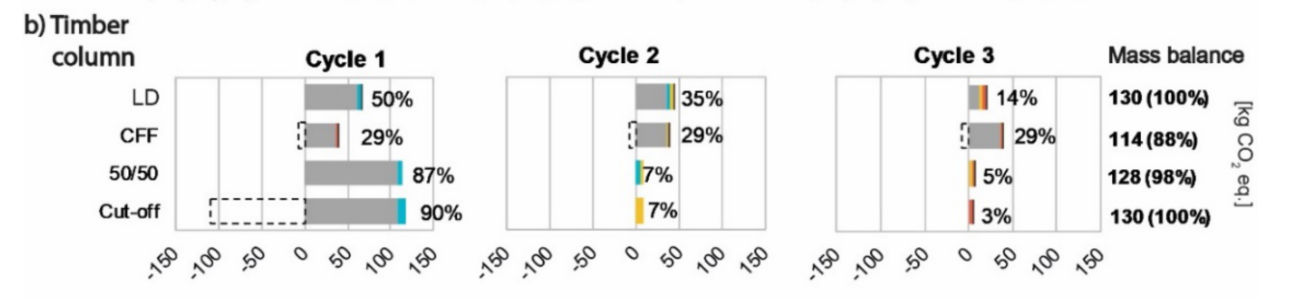

\* TODO other EPDs have other numbers, for example Limtre has 760km distance, 33kg for A1-A3 and 3.2kg for A5: https://www.epd-norge.no/heltreprodukter/limtre-article3247-320.html 

\* TODO we should consult the fossil vs bio approach to GWP calculation with LCA expert. In that EPD the difference is 28.9 vs -741 (2600% better)

\* TODO we should consider implementing more parameters than just GWP:
*  ODP Depletion potential of the stratospheric ozone layer;
*  POCP Formation potential of tropospheric photochemical oxidants;
*  AP Acidification potential of land and water;
*  EP Eutrophication potential;
*  ADPM Abiotic depletion potential for non fossil resources;
*  ADPE Abiotic depletion potential for fossil resources


### Generate pseudorandom numbers
For the material bank:

In [ ]:
import pandas as pd
import random

random.seed(3)

bank = pd.DataFrame()
bank['Length'] = [x/10 for x in random.choices(range(int(MIN_LENGTH*10), int(MAX_LENGTH*10)), k=BANK_COUNT)]        # [m], random between the range
bank['Area'] = bank.apply(lambda row: round((random.choice(range(0, int(MAX_AREA*10000)-int(MIN_AREA*10000))) /10000 /MAX_LENGTH * row['Length'] + MIN_AREA) * 10000)/10000, axis=1)        # [m2], random between the range but dependent on the length of the element
bank['Distance'] = bank.apply(lambda row: random.choice(BANK_DISTANCE), axis=1)   # [km], random of possible distances
bank['Price'] = bank.apply(lambda row: round(row['Length'] * row['Area'] * BANK_PRICE), axis=1)                          # [NOK], length * area * price (per m3)
bank['LCA_GWP'] = bank.apply(lambda row: round(row['Length'] * row['Area'] * (BANK_LCA_GWP_A1_A3 + BANK_LCA_GWP_A5)+ row['Distance'] * TRANSPORT_LCA_GWP * 10)/10, axis=1)    # [kgCO2e], length * area * processing_emissions + distance * transport_emissions  
bank['Weight'] = bank.apply(lambda row: round(row['Length'] * row['Area'] * DENSITY * 10)/10, axis=1)    # [kg], length * area * density

In [ ]:
bank

,Length,Area,Distance,Price,LCA_GWP,Weight
0,3.6,0.0064,50,92,1.6,11.3
1,6.9,0.0212,100,585,3.2,71.8
2,5.0,0.0529,150,1058,4.9,129.9
3,7.6,0.0080,100,243,3.2,29.9
4,7.8,0.0425,150,1326,4.9,162.8
5,1.7,0.0034,100,23,3.2,2.8
6,1.1,0.0076,100,33,3.2,4.1
7,10.2,0.0848,150,3460,5.1,424.7
8,3.8,0.0411,100,625,3.2,76.7
9,3.5,0.0256,150,358,4.8,44.0


Same for the design model:

In [ ]:
dsgn = pd.DataFrame()
dsgn['Length'] = [x/10 for x in random.choices(range(15, 100), k=DSGN_COUNT)]   # [m], random between 1.0 and 10.0 meters long
dsgn['Area'] = dsgn.apply(lambda row: round((random.choice(range(0, int(MAX_AREA*10000)-int(MIN_AREA*10000))) /10000 /MAX_LENGTH * row['Length'] + MIN_AREA)*10000)/10000, axis=1)        # [m2], random between the range but dependent on the length of the element
dsgn['Weight'] = dsgn.apply(lambda row: round(row['Length'] * row['Area'] * DENSITY *10)/10, axis=1)    # [kg], length * area * density

In [ ]:
dsgn

,Length,Area,Weight
0,9.9,0.0991,481.7
1,7.2,0.0724,255.9
2,2.8,0.0075,10.3
3,8.8,0.0342,147.8
4,9.6,0.0964,454.4


## Visualize the data

Show in 2D:

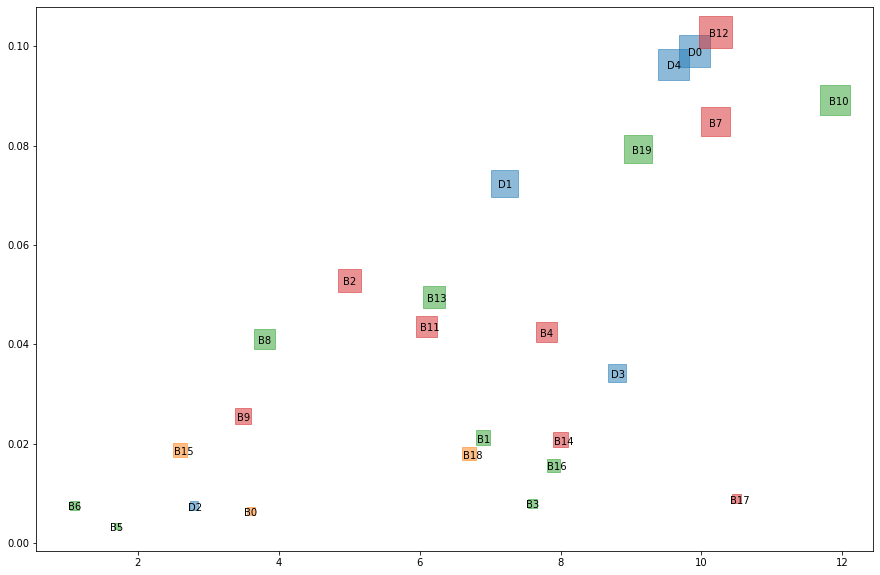

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def plot_elements(dsgn=dsgn, bank=bank, new=pd.DataFrame()):
  fig = plt.figure()
  fig.set_size_inches(15, 10)
  plt.scatter(dsgn['Length'], dsgn['Area'], alpha=0.5, s=dsgn['Area']*10000, marker="s", label='Design need')
  for d in BANK_DISTANCE:
    plt.scatter(bank[bank['Distance'] == d]['Length'], bank[bank['Distance'] == d]['Area'], alpha=0.5, s=bank[bank['Distance'] == d]['Area']*10000, marker="s", label=f'Bank stock {d}km away')

  for i in range(dsgn.shape[0]): 
    plt.annotate(f'D{i}', (dsgn.loc[i, 'Length']-0.09, dsgn.loc[i, 'Area']-0.001))
  for i in range(bank.shape[0]): 
    plt.annotate(f'B{i}', (bank.loc[i, 'Length']-0.09, bank.loc[i, 'Area']-0.001))

  # show the mapping:
  if not new.empty:
    for new_index, new_row in new.iterrows():
      if new_row['Bank_id']:
        # annotate elements to be reused
        plt.annotate("", xy=(dsgn.loc[new_index, 'Length'], dsgn.loc[new_index, 'Area']), xytext=(bank.loc[int(new_row['Bank_id']),'Length'], bank.loc[int(new_row['Bank_id']),'Area']),
                  arrowprops=dict(color='r', shrink=0.05, width=0.5))  
      else:
        # annotate new elements
        plt.annotate("NEW", xy=(new_row['Length']-0.16, new_row['Area']+0.0035), color='r')
        plt.plot(new_row['Length'], new_row['Area'], 'o', ms=30, mec='r', mfc='none', mew=2)

    plt.xlabel('Length [m]')
    plt.ylabel('Area [m2]')
    plt.title('Needed and available element sizes')
    plt.legend(loc="upper left")
    plt.show()

plot_elements(dsgn, bank)

If we don't consider cut waste, then both solutions [1] and [1] are equaly good. 

If cut waste is considered, then [1] is selected if assignment follows order from smallest to largest, and it produces less waste; [2] is selected if assignment follows order from largest to smallest. But there is a chance that approach [1] would result in largest element not finding it's equivalent (biggest loss).

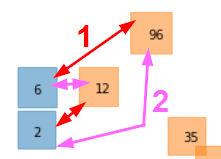

Visualize elements in 3D

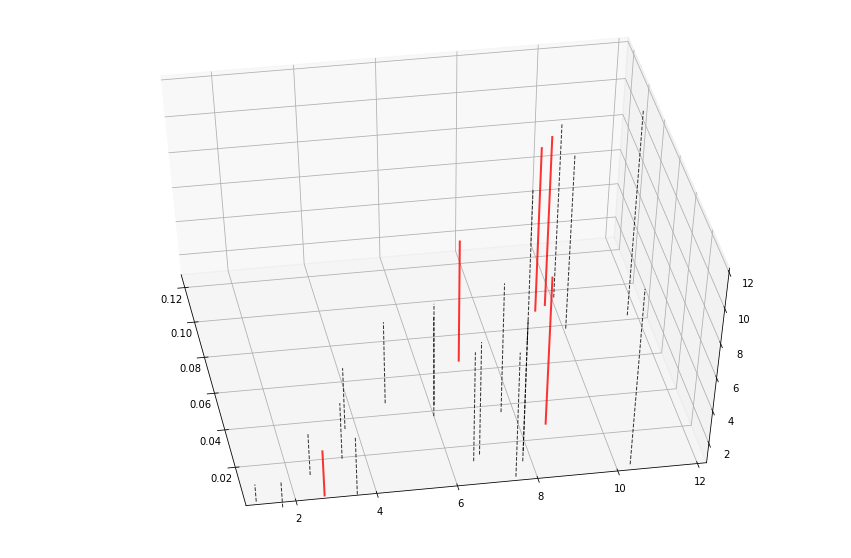

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = plt.axes(projection='3d')
ax.view_init(50, -10)

ax.set_xlim(MAX_AREA, MIN_AREA)
ax.set_ylim(MIN_LENGTH, MAX_LENGTH)
ax.set_zlim(MIN_LENGTH, MAX_LENGTH)

for i in range(bank.shape[0]):
    x = [bank.loc[i, 'Area'], bank.loc[i, 'Area']]
    y = [bank.loc[i, 'Length'], bank.loc[i, 'Length']]
    z = [0, bank.loc[i, 'Length']]
    ax.plot(x,y,z,'k--',alpha=0.8, linewidth=1)

for i in range(dsgn.shape[0]):
    x = [dsgn.loc[i, 'Area'], dsgn.loc[i, 'Area']]
    y = [dsgn.loc[i, 'Length'], dsgn.loc[i, 'Length']]
    z = [0, dsgn.loc[i, 'Length']]
    ax.plot(x,y,z, alpha=0.8, linewidth=2, color='red')

## Generate new elements
Allow for adding new (virgin) elements to the design

In [ ]:
def generate_new(length, area):
  random.seed(3)
  
  if not (type(length) == int or type(length) == float) and (type(area) == int or type(area) == float):
    raise Exception('Inputs to the function must be numbers')

  return pd.DataFrame(data={
    'Length':   length,         # [m]
    'Area':     area,           # [m2]
    'Distance': NEW_DISTANCE,   # [km]
    'Price':    round(NEW_PRICE * length * area),  # [NOK], length * area * price (per m3)
    'LCA_GWP':  round((length * area * (NEW_LCA_GWP_A1_A3 + NEW_LCA_GWP_A5) + NEW_DISTANCE * TRANSPORT_LCA_GWP)*10)/10,   # [kgCO2e], length * area * processing_emissions + distance * transport_emissions  
    'Weight':   round(length * area * DENSITY *10)/10,           # [kg]
    }, index=[0])

Verify by comparing bank element with new equivalent: 

In [ ]:
new_eq = generate_new(bank.loc[0, 'Length'], bank.loc[0, 'Area'])
print(f"First element in the bank is {round(100-bank.loc[0, 'Price']/new_eq.loc[0,'Price']*100)}% cheaper, and has {round(100-bank.loc[0, 'LCA_GWP']/new_eq.loc[0,'LCA_GWP']*100)}% less CO2, than new product of the same size.")

First element in the bank is 50% cheaper, and has 59% less CO2, than new product of the same size.


# Optimization

## [NEW] Only new elements
This is our reference solution. All other solutions with reuse of preowned elements should outperform that reference.

In [ ]:
new_set = pd.DataFrame()

import time
start_time = time.time()

for index, row in dsgn.iterrows():
  new_elem = generate_new(row['Length'], row['Area'])
  #append new element to the set:
  new_set = new_set.append(new_elem, ignore_index = True)

new_time = time.time()-start_time
print(f"Execution time: {round(new_time*1000)/1000} sec.")

print(f"If constructed from only new products, the design would have LCA-GWP {round(new_set['LCA_GWP'].sum())} kgCO2e, cost {round(new_set['Price'].sum())} NOK, and weight {round(new_set['Weight'].sum())} kg.")

Execution time: 0.011 sec.
If constructed from only new products, the design would have LCA-GWP 100 kgCO2e, cost 21999 NOK, and weight 1350 kg.


In [ ]:
new_set

,Length,Area,Distance,Price,LCA_GWP,Weight
0,9.9,0.0991,100,7849,33.1,481.7
1,7.2,0.0724,100,4170,19.1,255.9
2,2.8,0.0075,100,168,3.8,10.3
3,8.8,0.0342,100,2408,12.4,147.8
4,9.6,0.0964,100,7404,31.4,454.4


Plot LCA of each element in the bank and new

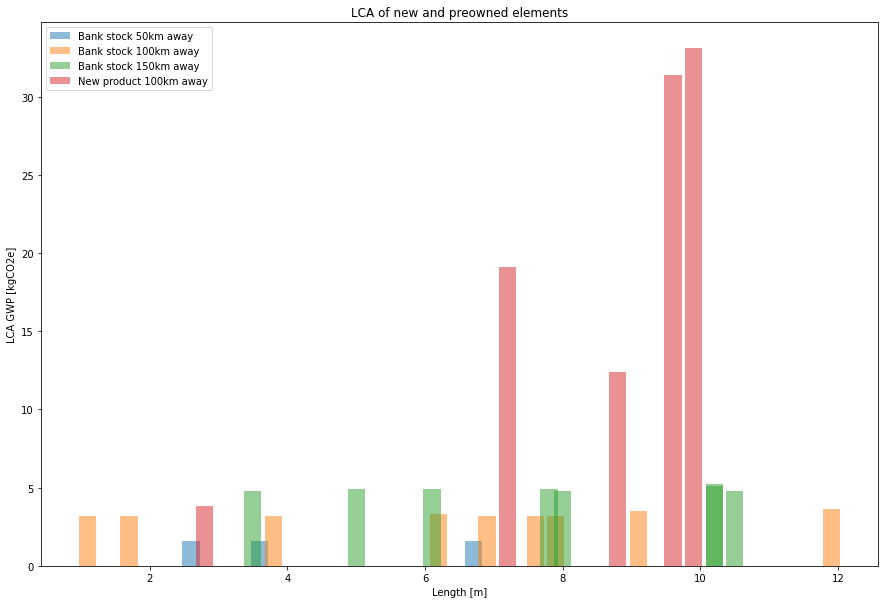

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)

for d in BANK_DISTANCE:
  plt.bar(bank[bank['Distance'] == d]['Length'], bank[bank['Distance'] == d]['LCA_GWP'], alpha=0.5, label=f'Bank stock {d}km away', width = 0.25)

plt.bar(new_set['Length'], new_set['LCA_GWP'], alpha=0.5, label=f'New product {NEW_DISTANCE}km away', width = 0.25)

plt.xlabel('Length [m]')
plt.ylabel('LCA GWP [kgCO2e]')
plt.title('LCA of new and preowned elements')
plt.legend(loc="upper left")
plt.show()

Plot price of each element in the bank and new

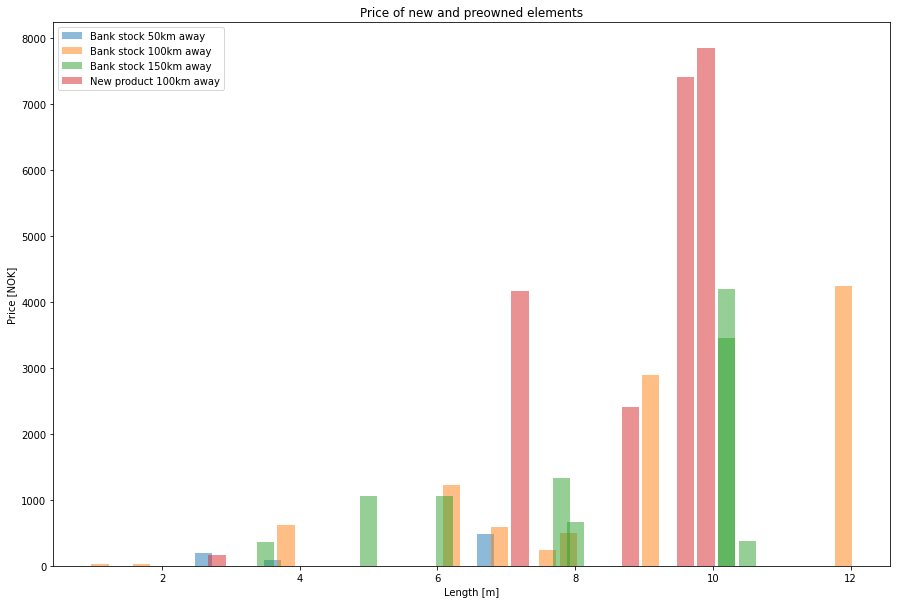

In [ ]:
fig = plt.figure()
fig.set_size_inches(15, 10)

for d in BANK_DISTANCE:
  plt.bar(bank[bank['Distance'] == d]['Length'], bank[bank['Distance'] == d]['Price'], alpha=0.5, label=f'Bank stock {d}km away', width = 0.25)

plt.bar(new_set['Length'], new_set['Price'], alpha=0.5, label=f'New product {NEW_DISTANCE}km away', width = 0.25)

plt.xlabel('Length [m]')
plt.ylabel('Price [NOK]')
plt.title('Price of new and preowned elements')
plt.legend(loc="upper left")
plt.show()

## [BFA] With brute force, ascending

Iterate through all the possibilities, and choose the best performing mapping.

In [ ]:
#measure time
import time
start_time = time.time()

# sort 'dsgn' and 'new_set' by volume, from smallest to largest: 
dsgn_sorted = dsgn.loc[(dsgn.Length * dsgn.Area).sort_values(ascending=True).index]
new_set_sorted = new_set.loc[(new_set.Length * new_set.Area).sort_values().index]

# Create dataframe by replacing according to the mapping:
bfa_set = new_set_sorted.copy()
bfa_set['Bank_id'] = None
bfa_set['Cut_length'] = None

# TODO make sure that two identical elements won't get the same mapping (drop after each match)

for dsgn_index, dsgn_row in dsgn_sorted.iterrows():
  for bank_index, bank_row in bank.iterrows():
    # check feasibility:
    if bank_row['Length'] >= dsgn_row['Length'] and bank_row['Area'] >= dsgn_row['Area']:
      # check if element not already taken:
      if bank_index not in list(bfa_set['Bank_id']):
        # check if both price and LCA are better than reference:
        if bank_row['Price'] <= new_set_sorted.loc[dsgn_index]['Price'] and bank_row['LCA_GWP'] <= new_set_sorted.loc[dsgn_index]['LCA_GWP']:
          # no mapping made yet:
          if not bfa_set.loc[dsgn_index, 'Bank_id']:
            bfa_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )
            bfa_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
            bfa_set.loc[dsgn_index, 'Weight'] = bfa_set.loc[dsgn_index, 'Length'] * bfa_set.loc[dsgn_index, 'Area'] * DENSITY
          # new mapping is better:
          elif bank_row['Price'] <= bank.loc[bfa_set.loc[dsgn_index, 'Bank_id']]['Price'] and bank_row['LCA_GWP'] <= bank.loc[bfa_set.loc[dsgn_index, 'Bank_id']]['LCA_GWP']:
            bfa_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )  
            bfa_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
            bfa_set.loc[dsgn_index, 'Weight'] = bfa_set.loc[dsgn_index, 'Length'] * bfa_set.loc[dsgn_index, 'Area'] * DENSITY

bfa_time = time.time()-start_time
print(f"Execution time: {round(bfa_time*10000)/10000} sec.")

bfa_cut_weight = (bfa_set['Cut_length'] * bfa_set['Area']).sum() * DENSITY
print(f"\nBrute force achieved LCA-GWP {round(bfa_set['LCA_GWP'].sum())} kgCO2e, cost {round(bfa_set['Price'].sum())} NOK, and weight {round(bfa_set['Weight'].sum())} kg. It would also result in {round(bfa_cut_weight)} kg of scrap waste.\n\n")

bfa_set

Execution time: 0.0236 sec.

Brute force achieved LCA-GWP 58 kgCO2e, cost 17510 NOK, and weight 1405 kg. It would also result in 104 kg of scrap waste.




,Length,Area,Distance,Price,LCA_GWP,Weight,Bank_id,Cut_length
2,2.8,0.0075,100,168,3.8,10.30000,None,None
3,8.8,0.0342,100,2408,12.4,147.80000,None,None
1,7.2,0.0793,100,2887,3.5,280.34136,19.0,1.9
4,9.6,0.1029,150,4198,5.2,485.02944,12.0,0.6
0,9.9,0.0991,100,7849,33.1,481.70000,None,None


In [ ]:
import json

dsgn.to_json(orient = 'columns')

'{"Length":{"0":9.9,"1":7.2,"2":2.8,"3":8.8,"4":9.6},"Area":{"0":0.0991,"1":0.0724,"2":0.0075,"3":0.0342,"4":0.0964},"Weight":{"0":481.7,"1":255.9,"2":10.3,"3":147.8,"4":454.4}}'

Visualize mapping

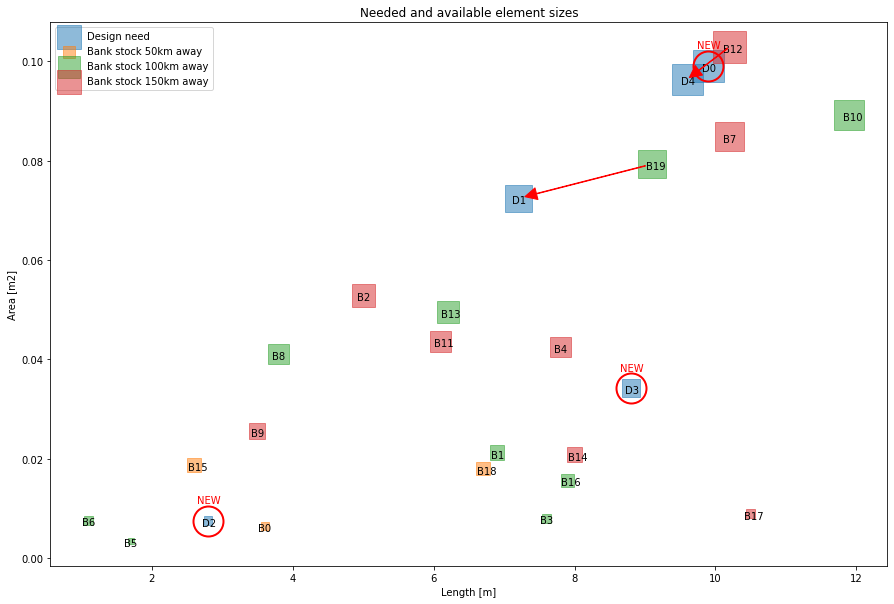

In [ ]:
plot_elements(dsgn, bank, bfa_set)

## [BFD] With brute force, descending

Iterate through all the possibilities, and choose the best performing mapping.

In [ ]:
#measure time
import time
start_time = time.time()

# sort 'dsgn' and 'new_set' by volume, from largest to smallest: 
dsgn_sorted = dsgn.loc[(dsgn.Length * dsgn.Area).sort_values(ascending=False).index]
new_set_sorted = new_set.loc[(new_set.Length * new_set.Area).sort_values().index]

# Create dataframe by replacing according to the mapping:
bfd_set = new_set_sorted.copy()
bfd_set['Bank_id'] = None
bfd_set['Cut_length'] = None

# TODO make sure that two identical elements won't get the same mapping (drop after each match)

for dsgn_index, dsgn_row in dsgn_sorted.iterrows():
  for bank_index, bank_row in bank.iterrows():
    # check feasibility:
    if bank_row['Length'] >= dsgn_row['Length'] and bank_row['Area'] >= dsgn_row['Area']:
      # check if element not already taken:
      if bank_index not in list(bfd_set['Bank_id']):
        # check if both price and LCA are better than reference (new):
        if bank_row['Price'] <= new_set_sorted.loc[dsgn_index]['Price'] and bank_row['LCA_GWP'] <= new_set_sorted.loc[dsgn_index]['LCA_GWP']:
          # no mapping made yet:
          if not bfd_set.loc[dsgn_index, 'Bank_id']:
            bfd_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )
            bfd_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
            bfd_set.loc[dsgn_index, 'Weight'] = bfd_set.loc[dsgn_index, 'Length'] * bfd_set.loc[dsgn_index, 'Area'] * DENSITY
          # new mapping is better:
          elif bank_row['Price'] <= bank.loc[bfd_set.loc[dsgn_index, 'Bank_id']]['Price'] and bank_row['LCA_GWP'] <= bank.loc[bfd_set.loc[dsgn_index, 'Bank_id']]['LCA_GWP']:
            bfd_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )  
            bfd_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
            bfd_set.loc[dsgn_index, 'Weight'] = bfd_set.loc[dsgn_index, 'Length'] * bfd_set.loc[dsgn_index, 'Area'] * DENSITY

bfd_time = time.time()-start_time
print(f"Execution time: {round(bfd_time*10000)/10000} sec.")

bfd_cut_weight = (bfd_set['Cut_length'] * bfd_set['Area']).sum() * DENSITY
print(f"\nBrute force achieved LCA-GWP {round(bfd_set['LCA_GWP'].sum())} kgCO2e, cost {round(bfd_set['Price'].sum())} NOK, and weight {round(bfd_set['Weight'].sum())} kg. It would also result in {round(bfd_cut_weight)} kg of scrap waste.\n\n")

bfd_set

Execution time: 0.0215 sec.

Brute force achieved LCA-GWP 56 kgCO2e, cost 17065 NOK, and weight 1393 kg. It would also result in 89 kg of scrap waste.




,Length,Area,Distance,Price,LCA_GWP,Weight,Bank_id,Cut_length
2,2.8,0.0075,100,168,3.8,10.30000,None,None
3,8.8,0.0342,100,2408,12.4,147.80000,None,None
1,7.2,0.0793,100,2887,3.5,280.34136,19.0,1.9
4,9.6,0.0964,100,7404,31.4,454.40000,None,None
0,9.9,0.1029,150,4198,5.2,500.18661,12.0,0.3


## [bfdl] With brute force, descending, but as a list of lists

Iterate through all the possibilities, and choose the best performing mapping.

In [ ]:
#measure time
import time
start_time = time.time()

# sort 'dsgn' and 'new_set' by volume, from largest to smallest: 
dsgn_sorted = dsgn.loc[(dsgn.Length * dsgn.Area).sort_values(ascending=False).index]
new_set_sorted = new_set.loc[(new_set.Length * new_set.Area).sort_values().index]

# Create dataframe by replacing according to the mapping:
bfdl_set = new_set_sorted.copy()
bfdl_set['Bank_id'] = None
bfdl_set['Cut_length'] = None

# dsgn_sorted = new_set_sorted.to_dict('index')
# new_set_sorted = new_set_sorted.to_dict('index')
# bfdl_set = bfdl_set.to_dict('index')

dsgn_sorted = new_set_sorted.values.tolist()
new_set_sorted = new_set_sorted.values.tolist()
bfdl_set = bfdl_set.values.tolist()

# TODO make sure that two identical elements won't get the same mapping (drop after each match)

# for dsgn_index, dsgn_row in dsgn_sorted.iterrows():
#   for bank_index, bank_row in bank.iterrows():
#     # check feasibility:
#     if bank_row['Length'] >= dsgn_row['Length'] and bank_row['Area'] >= dsgn_row['Area']:
#       # check if element not already taken:
#       if bank_index not in list(bfd_set['Bank_id']):
#         # check if both price and LCA are better than reference (new):
#         if bank_row['Price'] <= new_set_sorted.loc[dsgn_index]['Price'] and bank_row['LCA_GWP'] <= new_set_sorted.loc[dsgn_index]['LCA_GWP']:
#           # no mapping made yet:
#           if not bfd_set.loc[dsgn_index, 'Bank_id']:
#             bfdl_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )
#             bfdl_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
#             bfdl_set.loc[dsgn_index, 'Weight'] = bfdl_set.loc[dsgn_index, 'Length'] * bfd_set.loc[dsgn_index, 'Area'] * DENSITY
#           # new mapping is better:
#           elif bank_row['Price'] <= bank.loc[bfd_set.loc[dsgn_index, 'Bank_id']]['Price'] and bank_row['LCA_GWP'] <= bank.loc[bfd_set.loc[dsgn_index, 'Bank_id']]['LCA_GWP']:
#             bfdl_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )  
#             bfdl_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
#             bfdl_set.loc[dsgn_index, 'Weight'] = bfdl_set.loc[dsgn_index, 'Length'] * bfd_set.loc[dsgn_index, 'Area'] * DENSITY

bfdl_time = time.time()-start_time
print(f"Execution time: {round(bfdl_time*10000)/10000} sec.")

bfdl_cut_weight = (bfdl_set['Cut_length'] * bfdl_set['Area']).sum() * DENSITY
print(f"\nBrute force achieved LCA-GWP {round(bfdl_set['LCA_GWP'].sum())} kgCO2e, cost {round(bfdl_set['Price'].sum())} NOK, and weight {round(bfdl_set['Weight'].sum())} kg. It would also result in {round(bfdl_cut_weight)} kg of scrap waste.\n\n")

bfdl_set

AttributeError: ignored

## [MAT] With matrix transformations

In [ ]:
dsgn

,Length,Area,Weight
0,9.9,0.0991,481.7
1,7.2,0.0724,255.9
2,2.8,0.0075,10.3
3,8.8,0.0342,147.8
4,9.6,0.0964,454.4


TEMPORARY MOCK! It imitates the perfect match for element no.2 from the design set.

In [ ]:
mock = pd.Series([2.9, 0.0078, 50, 100, 1, 10.3], index = bank.columns)
bank = bank.append(mock, ignore_index=True)
bank

,Length,Area,Distance,Price,LCA_GWP,Weight
0,3.6,0.0064,50.0,92.0,1.6,11.3
1,6.9,0.0212,100.0,585.0,3.2,71.8
2,5.0,0.0529,150.0,1058.0,4.9,129.9
3,7.6,0.0080,100.0,243.0,3.2,29.9
4,7.8,0.0425,150.0,1326.0,4.9,162.8
5,1.7,0.0034,100.0,23.0,3.2,2.8
6,1.1,0.0076,100.0,33.0,3.2,4.1
7,10.2,0.0848,150.0,3460.0,5.1,424.7
8,3.8,0.0411,100.0,625.0,3.2,76.7
9,3.5,0.0256,150.0,358.0,4.8,44.0


Create mapping vector, where None means that no mapping was made and new element should be applied:

In [ ]:
# zero's matrix:
mapping = pd.DataFrame(None, index=dsgn.index.values.tolist() , columns=['Bank_id'] )
mapping

,Bank_id
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


Create fitness matrix with 1's if MB element satisfies minimum length and area criteria.

In [ ]:
# zero's matrix:
m_geometry = pd.DataFrame(np.nan, index=dsgn.index.values.tolist() , columns=bank.index.values.tolist() )

# assign 1 when length pass the criteria: 
for i in range(m_geometry.shape[0]):
    for j in range(m_geometry.shape[1]):
        if dsgn.loc[i]['Length'] <= bank.loc[j]['Length'] and dsgn.loc[i]['Area'] <= bank.loc[j]['Area']:
          m_geometry.iloc[i,j] = 1

m_geometry

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminate rows with no match (meaning, that dsgn has element longer than longest in bank):

In [ ]:
m_geometry.drop(m_geometry[m_geometry.sum(axis=1) == 0].index, inplace=True)
print(f"Eliminated {dsgn.shape[0] -  m_geometry.shape[0]} elements from the new design (matrix rows), for which no good match was found in the bank.")

Eliminated 0 elements from the new design (matrix rows), for which no good match was found in the bank.


Eliminate columns with no match (meaning that there are elements in bank shorter than shortest in dsgn):

In [ ]:
m_geometry.drop(m_geometry.columns[m_geometry.sum() == 0], axis=1, inplace=True)
print(f"Eliminated {bank.shape[0] -  m_geometry.shape[1]} elements from the bank (matrix columns), that were shorter than needed.")

m_geometry

Eliminated 4 elements from the bank (matrix columns), that were shorter than needed.


,1,2,3,4,7,8,9,10,11,12,13,14,16,17,18,19,20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For the remaining elements with 1 in the fittness matrix, we need to calculate waste:

In [ ]:
m_waste = pd.DataFrame(np.nan, index=m_geometry.index, columns=m_geometry.columns)
m_price = pd.DataFrame(np.nan, index=m_geometry.index, columns=m_geometry.columns)
m_lca = pd.DataFrame(np.nan, index=m_geometry.index, columns=m_geometry.columns)

for i, row in m_geometry.iterrows():
  for j in row.index:
    if row[j] == 1:
      # don't calculate if lca or price for new is lower:
      if new_set.loc[i, 'LCA_GWP'] > bank.loc[j]['LCA_GWP'] and new_set.loc[i, 'Price'] > bank.loc[j]['Price']:
        # cut length: 
        cut_length = bank.loc[j]['Length'] - dsgn.loc[i]['Length']
        m_waste.loc[i, j] = round(cut_length * bank.loc[j]['Area'], 3) # volume
        m_price.loc[i, j] = round(bank.loc[j]['Price'],3) # don't take into account that cut part can be sold  
        m_lca.loc[i, j] = round(bank.loc[j]['LCA_GWP'], 3) # don't take into account that cut part can be recycled

m_waste

,1,2,3,4,7,8,9,10,11,12,13,14,16,17,18,19,20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminate rows with no match (meaning, that dsgn has element longer than longest in bank) and columns with no match (meaning that there are elements in bank shorter than shortest in dsgn):

In [ ]:
m_geometry.drop(m_geometry[m_lca.sum(axis=1) == 0].index, inplace=True)
m_geometry.drop(m_geometry.columns[m_lca.sum() == 0], axis=1, inplace=True)

m_waste.drop(m_waste[m_lca.sum(axis=1) == 0].index, inplace=True)
m_waste.drop(m_waste.columns[m_lca.sum() == 0], axis=1, inplace=True)

m_price.drop(m_price[m_lca.sum(axis=1) == 0].index, inplace=True)
m_price.drop(m_price.columns[m_lca.sum() == 0], axis=1, inplace=True)

m_lca.drop(m_lca[m_lca.sum(axis=1) == 0].index, inplace=True)
m_lca.drop(m_lca.columns[m_lca.sum() == 0], axis=1, inplace=True)

m_waste

,7,12,19,20
0,NaN,0.031,NaN,NaN
1,0.254,NaN,0.151,NaN
2,NaN,NaN,NaN,0.001
4,NaN,0.062,NaN,NaN


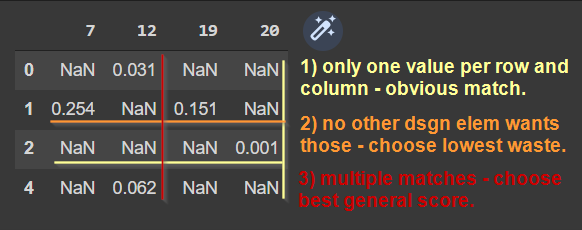

Apply mapping if only one match in a row and column:

In [ ]:
for index, row in m_waste.iterrows():
  if row.sum() == 1:
    # check if that column with only one item has only one value --> obvious match! 
    # .count()

# 
    # Before I had for whole matrix: if (m_geometry.sum(axis=1) == 1).sum() > 0:
    print('!!!!!! TODO here should be a mapping... !!!!!!!!!')
    # row_id = fit[fit.sum(axis=1) == 1].index[0]
    # col_id = fit.loc[row_id].idxmax()

    # mapping[row_id] = col_id
    # col_loc = MB_labels.index(col_id)
    # row_loc = ND_labels.index(row_id)
    # MB_updated[col_loc] = MB_updated[col_loc] - ND[row_loc]

    # fit.drop('D2', inplace=True)

If many rows share the same column and not any other column - select one with lowest waste

In [ ]:
# TODO

If multiple rows share multiple columns do the comparison

In [ ]:
# TODO

## [GEN] With genetic algorithm

In [ ]:
!pip3 install pygad
import pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.4 MB/s 


In [ ]:
# To be continued...

## [LIN] With linear programming (OR Tolls)

In [ ]:
# To be continued...

## [PAR] With Pareto Front

In [ ]:
# To be continued...

## [MLE] With machine learning (?)

In [ ]:
# To be continued...

## Comparison

In [ ]:
result = pd.DataFrame( 
    [
      [round(new_set['Price'].sum()), round(new_set['LCA_GWP'].sum()), round(new_set['Weight'].sum()), 0, round(new_time*1000)/1000],
      [round(bfa_set['Price'].sum()), round(bfa_set['LCA_GWP'].sum()), round(bfa_set['Weight'].sum()), round(bfa_cut_weight), round(bfa_time*1000)/1000],
      [round(bfd_set['Price'].sum()), round(bfd_set['LCA_GWP'].sum()), round(bfd_set['Weight'].sum()), round(bfd_cut_weight), round(bfd_time*1000)/1000],
      [round(bfdl_set['Price'].sum()), round(bfdl_set['LCA_GWP'].sum()), round(bfdl_set['Weight'].sum()), round(bfdl_cut_weight), round(bfdl_time*1000)/1000]
    ],
    index=["only new","brute force asc", "brute force desc"],
    columns = ["Price", "LCA_GWP", "Weight", "Cut_weight", "Exec.time"])

result

,Price,LCA_GWP,Weight,Cut_weight,Exec.time
only new,21999,100,1350,0,0.012
brute force asc,17510,58,1405,104,0.024
brute force desc,17065,56,1393,89,0.026
